In [12]:
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import numpy as np
import os
import nrrd
import pytorch_lightning as pl
from monai.data import Dataset, DataLoader
from monai.transforms import Compose, Lambda, RandSpatialCrop, RandRotate90, ToTensor
from monai.networks.nets import UNet
#from monai.losses import DiceLoss
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [22]:
import shutil

def clear_tensorboard_logs(log_dir):
    # Ensure the directory exists
    if os.path.exists(log_dir):
        # Delete the directory and its contents
        shutil.rmtree(log_dir)
        print("TensorBoard logs cleared successfully.")
    else:
        print("TensorBoard logs directory not found.")

def clear_logs(logs_dir):
    """Clear all logs in the specified directory."""
    try:
        shutil.rmtree(logs_dir)
        print(f"All logs in {logs_dir} have been cleared.")
    except FileNotFoundError:
        print(f"No logs found in {logs_dir}.")
def clear_runs_and_logs(logs_dir):
    """Clear all runs and logs in the specified directory."""
    try:
        shutil.rmtree(logs_dir)
        print(f"All runs and logs in {logs_dir} have been cleared.")
    except FileNotFoundError:
        print(f"No runs or logs found in {logs_dir}.")

# Specify the directory containing all runs and logs
runs_and_logs_dir = "./runs_and_logs/"
log_dir = "./logs/"
tensorboard_logs_dir = "./tensorboard_logs/"
lightning_logs_dir = "./lightning_logs/"
# Clear TensorBoard logs
clear_tensorboard_logs(log_dir)
clear_logs(lightning_logs_dir)
clear_runs_and_logs(runs_and_logs_dir)

TensorBoard logs directory not found.
No logs found in ./lightning_logs/.
No runs or logs found in ./runs_and_logs/.


In [14]:
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.unet = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=3,  # Update to 3 output channels
            channels=(16, 32, 64, 128, 64),  # Trying one channel EXPERIMENT 
            strides=(2, 2, 2, 2),
            num_res_units=2,
        )
        # Define class weights
        class_weights = torch.tensor([0.2, 0.4, 0.4])
        self.loss_function = CrossEntropyLoss(weight=class_weights)

    def forward(self, x):
        return self.unet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.unet(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())  # Ensure labels are in the range [0, 2]
        self.log('train_loss', loss, prog_bar=True)

        # Reconstruct and display a single slice from the first training image every other epoch
        if self.current_epoch % 150 == 0 and batch_idx == 0:
            original_slice = x[0, 0, :, :, 128].detach().cpu().numpy()  # Select a single slice from the 3D volume
            reconstruction_slice = np.argmax(x_hat[0,:,:,:,128], axis=0) # Select a single slice from the 3D reconstruction

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_slice, cmap='gray')
            plt.title('Original Train Slice')
            plt.subplot(1, 2, 2)
            plt.imshow(reconstruction_slice, cmap='gray')
            plt.title('Reconstructed Train Slice')
            plt.show()

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.unet(x)
        loss = self.loss_function(x_hat, y.squeeze(1).long())  # Ensure labels are in the range [0, 2]
        self.log('val_loss', loss, prog_bar=True)

        # Reconstruct and display a single slice from the first validation image every other epoch
        if self.current_epoch % 150 == 0 and batch_idx == 0:
            original_slice = x[0, 0, :, :, 128].detach().cpu().numpy()  # Select a single slice from the 3D volume
            reconstruction_slice = np.argmax(x_hat[0,:,:,:,128], axis=0)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(original_slice, cmap='gray')
            plt.title('Original Val Slice')
            plt.subplot(1, 2, 2)
            plt.imshow(reconstruction_slice, cmap='gray')
            plt.title('Reconstructed Val Slice')
            plt.show()

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


# Define dataset and data loaders for both training and validation sets
train_data_dir = "./images/TrainFullLabels70"
val_data_dir = "./images/ValFullLabels30"

transform = Compose([
    Lambda(func=lambda x: np.expand_dims(x, 0) if x.ndim == 3 else x),
    RandSpatialCrop((256, 256, 256), random_size=False),
    RandRotate90(prob=0.5),
    ToTensor(dtype=torch.float32)
])

class MyDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.nrrd')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data, header = nrrd.read(file_path)
        if self.transform:
            data = self.transform(data)
        return data, data

train_dataset = MyDataset(train_data_dir, transform)
val_dataset = MyDataset(val_data_dir, transform)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# Define a custom callback to plot both training and validation losses

class PlotLossCallback(pl.Callback):
    def __init__(self, log_dir):
        super().__init__()
        self.log_dir = log_dir

    def on_train_start(self, trainer, pl_module):
        # Clear previous graphs
        tf.compat.v1.reset_default_graph()
        self.writer = SummaryWriter(self.log_dir)

    def on_train_epoch_end(self, trainer, pl_module, **kwargs):
        epoch = trainer.current_epoch
        train_loss = trainer.callback_metrics['train_loss'].cpu().item()
        val_loss = trainer.callback_metrics['val_loss'].cpu().item()

        # Write both training and validation loss to the same graph with epoch as global step
        self.writer.add_scalars('64 Channel Loss', {'training' : train_loss,
                                                                'validation' : val_loss }, global_step=epoch +1 )
    def on_train_end(self, trainer, pl_module):
        self.writer.close()

#early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=80)
#getting rid of early stop callback for now 
# Define Lightning trainer
trainer = pl.Trainer(
    max_epochs=1500,
    callbacks=[PlotLossCallback("./logs/")],
    profiler='simple')


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | unet          | UNet             | 2.1 M 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.512     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

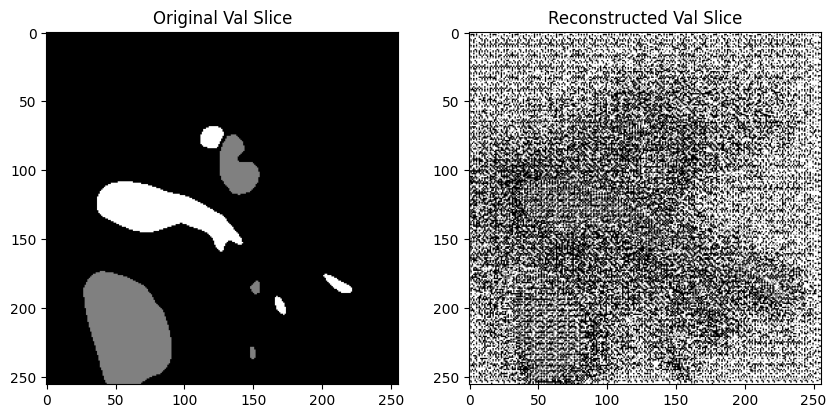

c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\tgafrick\Documents\Github\RA4-Project\venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Epoch 0:   0%|          | 0/18 [00:00<?, ?it/s] 

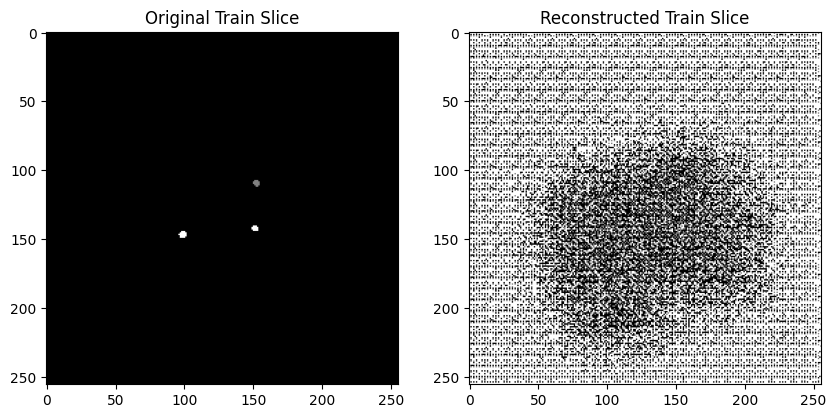

Epoch 0: 100%|██████████| 18/18 [01:26<00:00,  0.21it/s, v_num=8, train_loss=0.589]

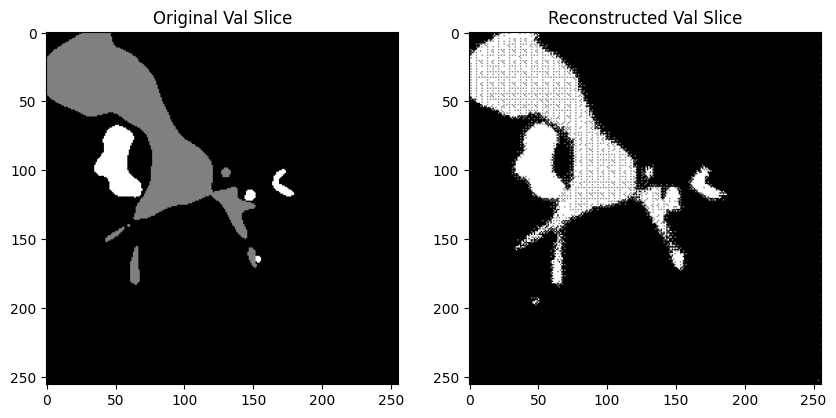

Epoch 150:   0%|          | 0/18 [00:00<?, ?it/s, v_num=8, train_loss=0.00132, val_loss=0.00167]          

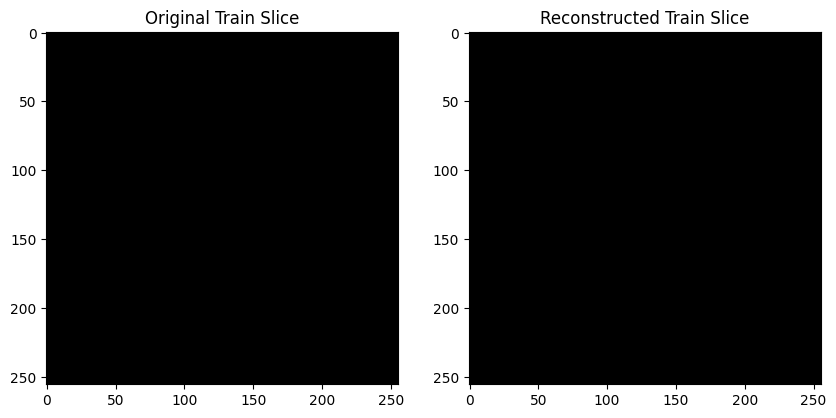

Epoch 150: 100%|██████████| 18/18 [01:23<00:00,  0.21it/s, v_num=8, train_loss=0.000702, val_loss=0.00167]

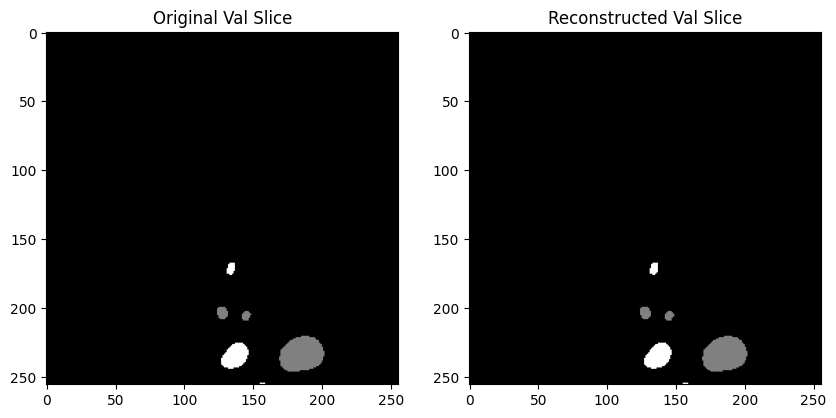

Epoch 300:   0%|          | 0/18 [00:00<?, ?it/s, v_num=8, train_loss=0.000693, val_loss=0.00048]          

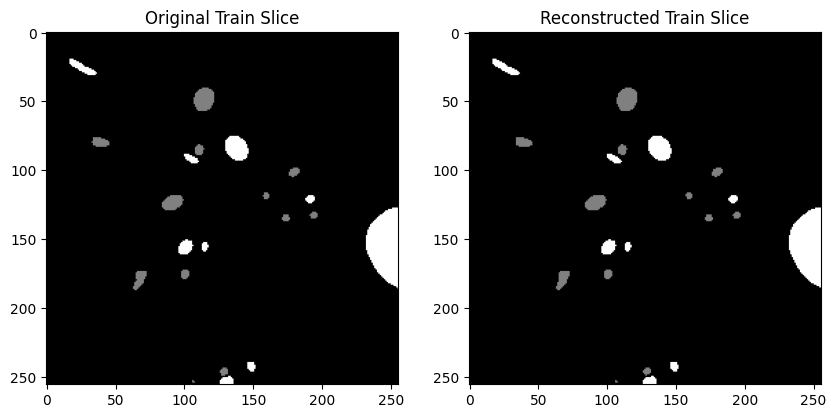

Epoch 300: 100%|██████████| 18/18 [01:23<00:00,  0.21it/s, v_num=8, train_loss=0.000909, val_loss=0.00048]

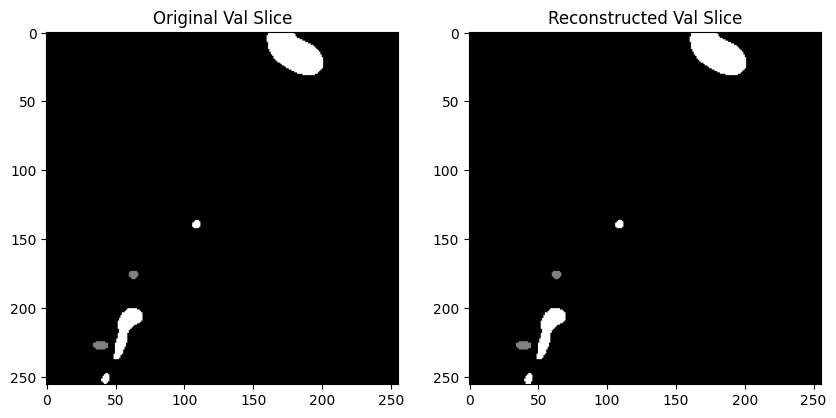

Epoch 450:   0%|          | 0/18 [00:00<?, ?it/s, v_num=8, train_loss=0.000346, val_loss=0.000251]         

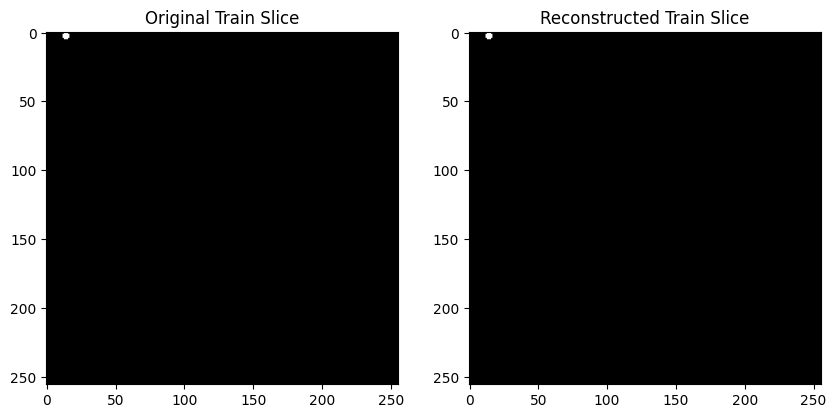

Epoch 450: 100%|██████████| 18/18 [01:23<00:00,  0.21it/s, v_num=8, train_loss=0.000509, val_loss=0.000251]

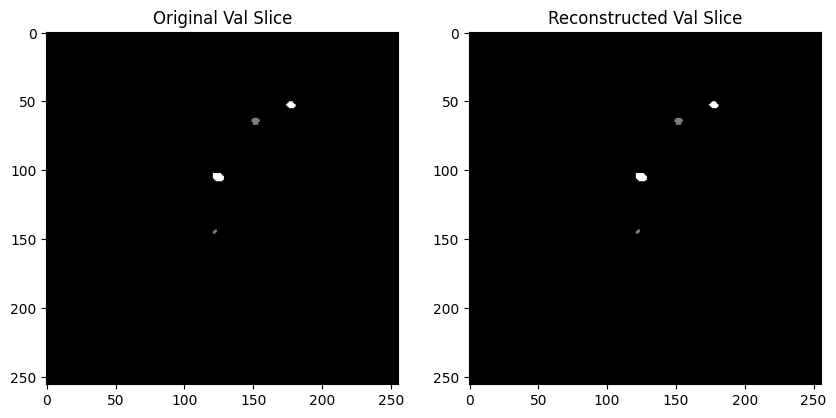

Epoch 600:   0%|          | 0/18 [00:00<?, ?it/s, v_num=8, train_loss=0.00032, val_loss=0.000332]          

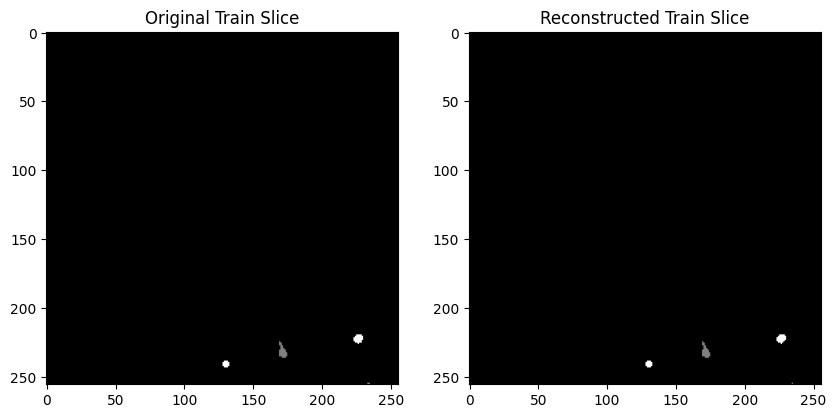

Epoch 600: 100%|██████████| 18/18 [01:23<00:00,  0.22it/s, v_num=8, train_loss=0.000252, val_loss=0.000332]

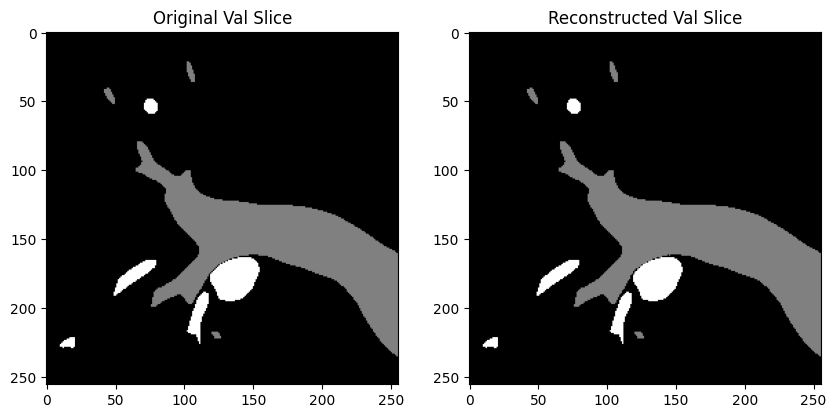

Epoch 750:   0%|          | 0/18 [00:00<?, ?it/s, v_num=8, train_loss=0.000111, val_loss=7.5e-5]           

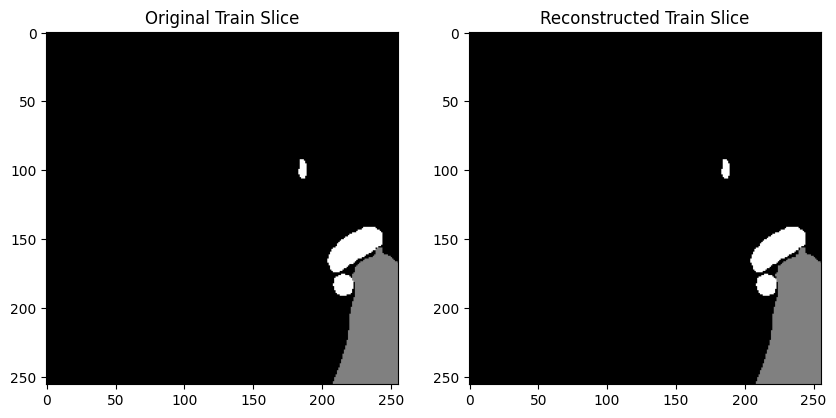

Epoch 750: 100%|██████████| 18/18 [01:23<00:00,  0.21it/s, v_num=8, train_loss=6.85e-5, val_loss=7.5e-5]

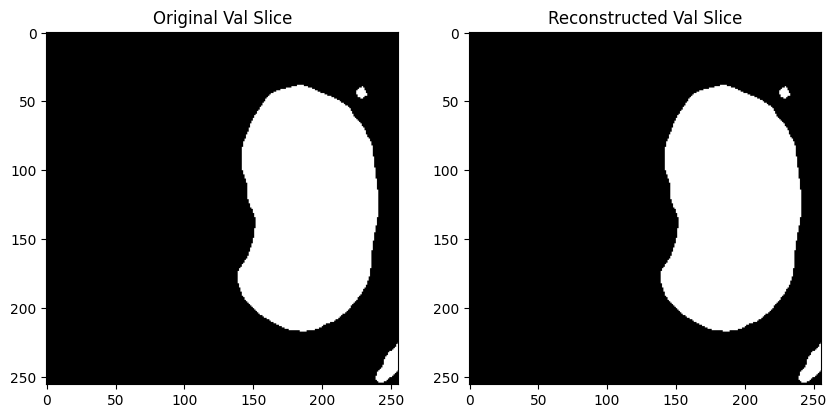

Epoch 900:   0%|          | 0/18 [00:00<?, ?it/s, v_num=8, train_loss=4.58e-5, val_loss=6.41e-5]           

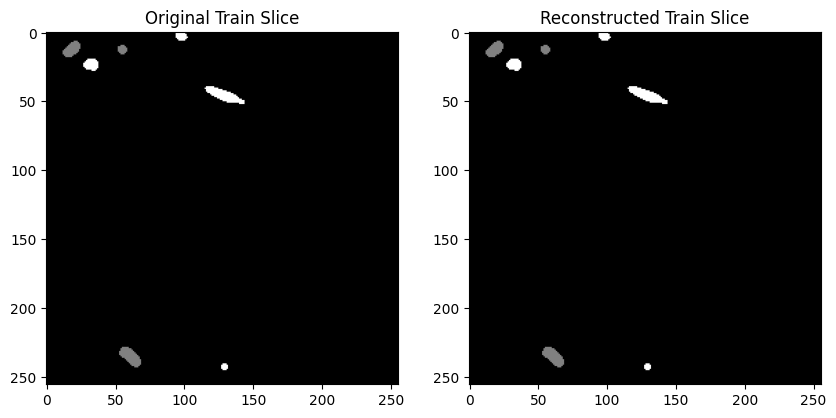

Epoch 900: 100%|██████████| 18/18 [01:23<00:00,  0.22it/s, v_num=8, train_loss=0.000102, val_loss=6.41e-5]

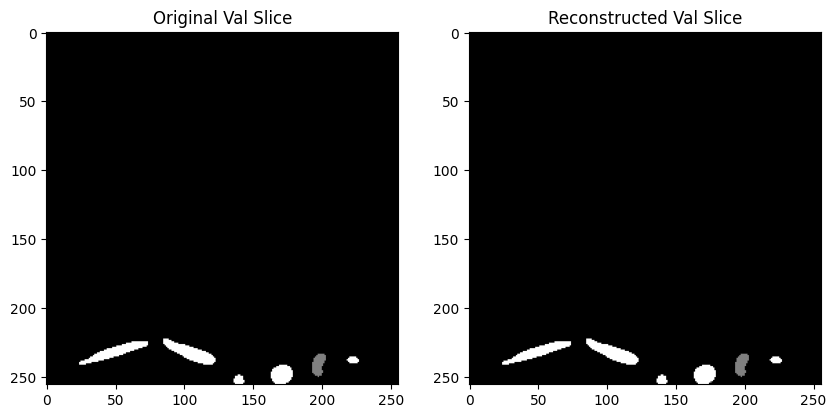

Epoch 1050:   0%|          | 0/18 [00:00<?, ?it/s, v_num=8, train_loss=6.28e-5, val_loss=3.75e-5]          

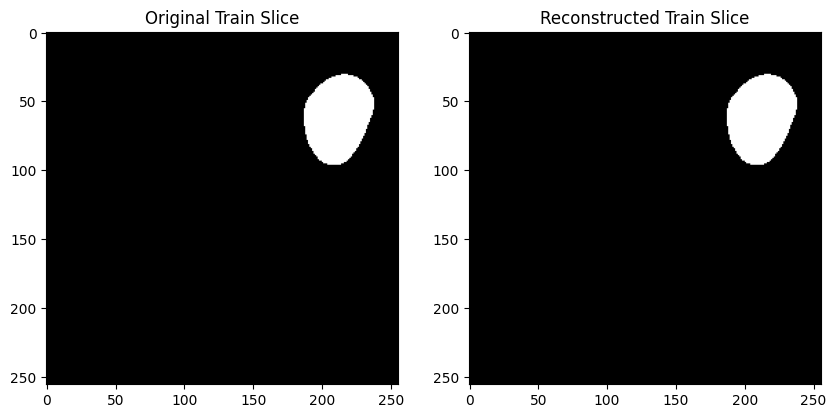

Epoch 1050: 100%|██████████| 18/18 [01:24<00:00,  0.21it/s, v_num=8, train_loss=4.12e-5, val_loss=3.75e-5] 

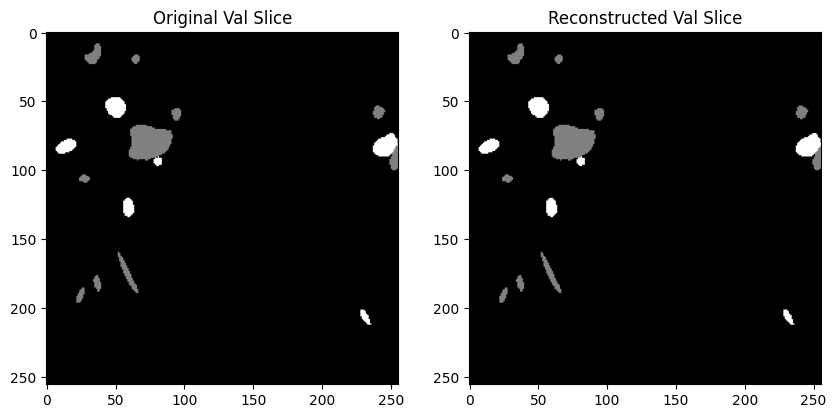

Epoch 1200:   0%|          | 0/18 [00:00<?, ?it/s, v_num=8, train_loss=9.6e-5, val_loss=2.05e-5]            

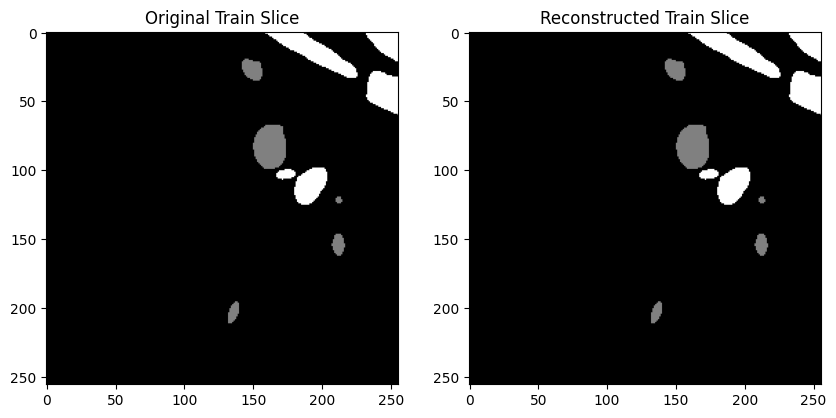

Epoch 1200: 100%|██████████| 18/18 [01:23<00:00,  0.21it/s, v_num=8, train_loss=1.08e-5, val_loss=2.05e-5]

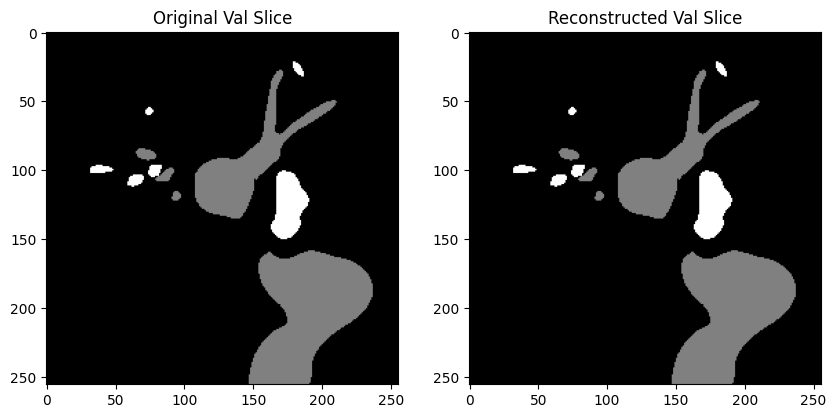

Epoch 1350:   0%|          | 0/18 [00:00<?, ?it/s, v_num=8, train_loss=3.47e-5, val_loss=3.68e-5]           

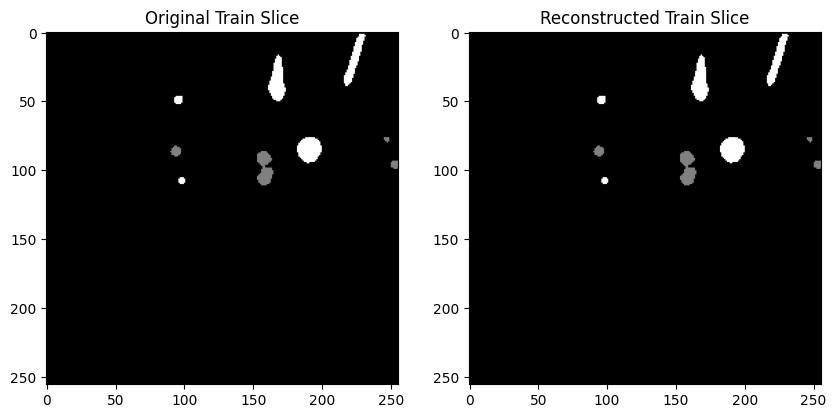

Epoch 1350: 100%|██████████| 18/18 [01:23<00:00,  0.21it/s, v_num=8, train_loss=4.25e-5, val_loss=3.68e-5] 

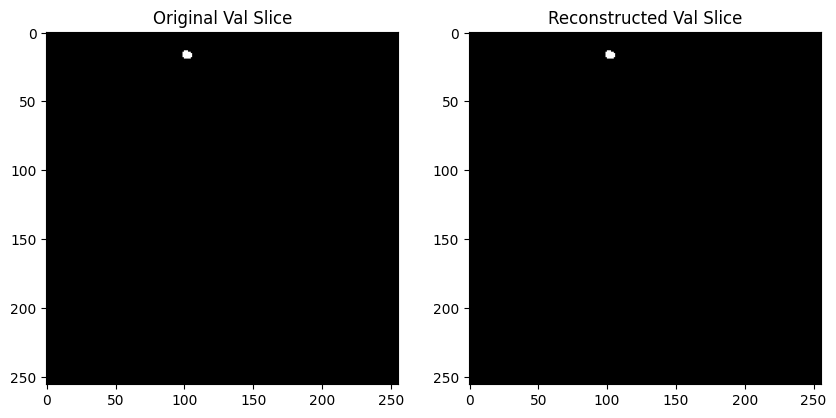

Epoch 1499: 100%|██████████| 18/18 [01:38<00:00,  0.18it/s, v_num=8, train_loss=2.35e-5, val_loss=5.84e-5]  

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1499: 100%|██████████| 18/18 [01:39<00:00,  0.18it/s, v_num=8, train_loss=2.35e-5, val_loss=5.84e-5]


FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  1386098        

In [15]:
# Initialize model and start training
model = AutoEncoder()
trainer.fit(model, train_dataloader, val_dataloader)
torch.save(model.state_dict(), "./images/Model/model_64channel.pth")

In [3]:
#load in model 
model = AutoEncoder()
model.load_state_dict(torch.load("./images/Model/model_1channel.pth")) 

<All keys matched successfully>

In [ ]:
#2factor downsample 3d image graphing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

test_dir = "./images/3dTest"
test_data = MyDataset(test_dir, transform)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

model.eval()

# Define the color map
color_map = np.array([
    [0, 0, 0, 0],      # Transparent for background (0)
    [255, 0, 0, 255],  # Red for arteries (1)
    [0, 0, 255, 255]   # Blue for veins (2)
], dtype=np.uint8)

# Downsampling factor
downsample_factor = 2

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(test_dataloader):
        x_hat = model(x)
        
        # Reconstruct and display the whole volume from the first test image
        original_volume = x[0, 0, :, :, :].detach().cpu().numpy().astype(int)  

        # Downsample original volume
        original_volume_downsampled = original_volume[::downsample_factor, ::downsample_factor, ::downsample_factor]

        reconstruction_volume = np.argmax(x_hat[0,:,:,:,:], axis=0)

        # Downsample reconstructed volume
        reconstruction_volume_downsampled = reconstruction_volume[::downsample_factor, ::downsample_factor, ::downsample_factor]

        # Downsample color map along the first axis to match the number of unique values in the downsampled volume
        color_map_downsampled = color_map[:len(np.unique(original_volume_downsampled))]

        # Plot original and reconstructed volumes with titles using Matplotlib
        fig = plt.figure(figsize=(10, 5))

        # Plot original volume with assigned colors and no edge color
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.set_title('Original Volume')

        # Define colors for each voxel value in the original volume using the downsampled color map
        original_colors = np.take(color_map_downsampled, original_volume_downsampled, axis=0) / 255.0
        ax1.voxels(original_volume_downsampled, facecolors=original_colors)

        # Plot reconstructed volume with assigned colors and no edge color
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.set_title('Reconstructed Volume')

        # Define colors for each voxel value in the reconstructed volume using the downsampled color map
        reconstruction_colors = np.take(color_map_downsampled, reconstruction_volume_downsampled, axis=0) / 255.0
        ax2.voxels(reconstruction_volume_downsampled, facecolors=reconstruction_colors)

        plt.show()


In [ ]:
#Testing model

test_dir = "./images/Test"
test_data = MyDataset(test_dir, transform)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle= False)

model.eval()

with torch.no_grad():
    for batch_idx, (x,_) in enumerate(test_dataloader):
        x_hat = model(x)
        
        # Reconstruct and display a single slice from the first test image
        original_slice = x[0, 0, :, :, 128].detach().cpu().numpy() 
        reconstruction_slice = np.argmax(x_hat[0,:,:,:,128], axis=0)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title('Original Test Slice')
        plt.subplot(1, 2, 2)
        plt.imshow(reconstruction_slice, cmap='gray')
        plt.title('Reconstructed Test Slice')
        plt.show()